In [ ]:
# MIT License

# Copyright (c) 2020 Daniel Bourke

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# Project 3: BitPredict: Time-Series Forecasting

# Get workspace ready

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.18.0
TF Hub version: 0.16.1


In [3]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [4]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# 1.Data pre-processing

## Get the series data

In [5]:
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [7]:
len(df)

2787

In [8]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


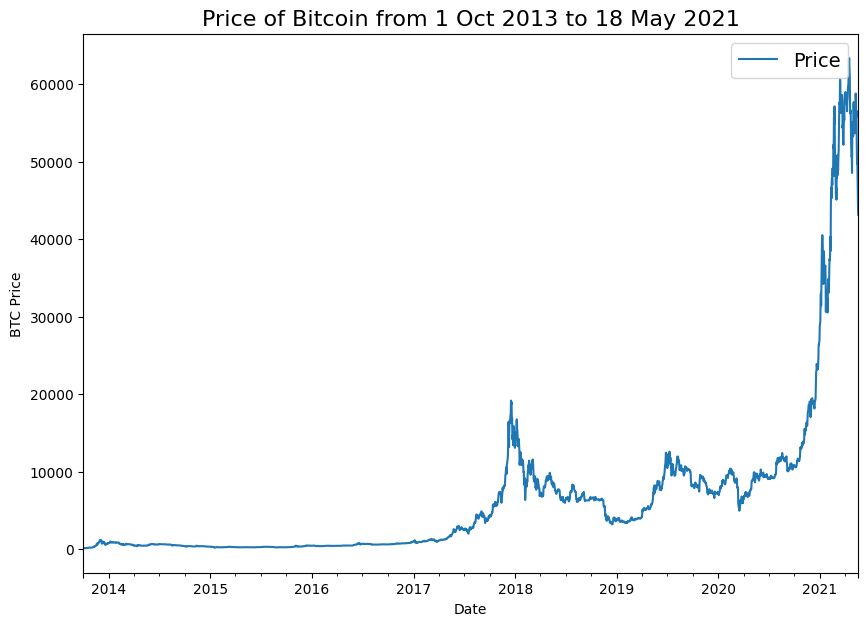

In [9]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

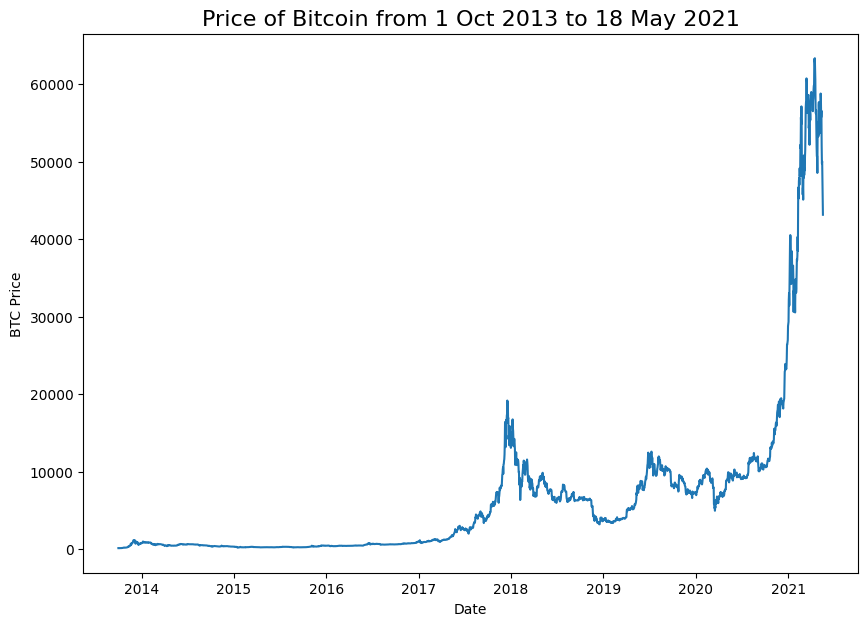

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format and visualize datasets

In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

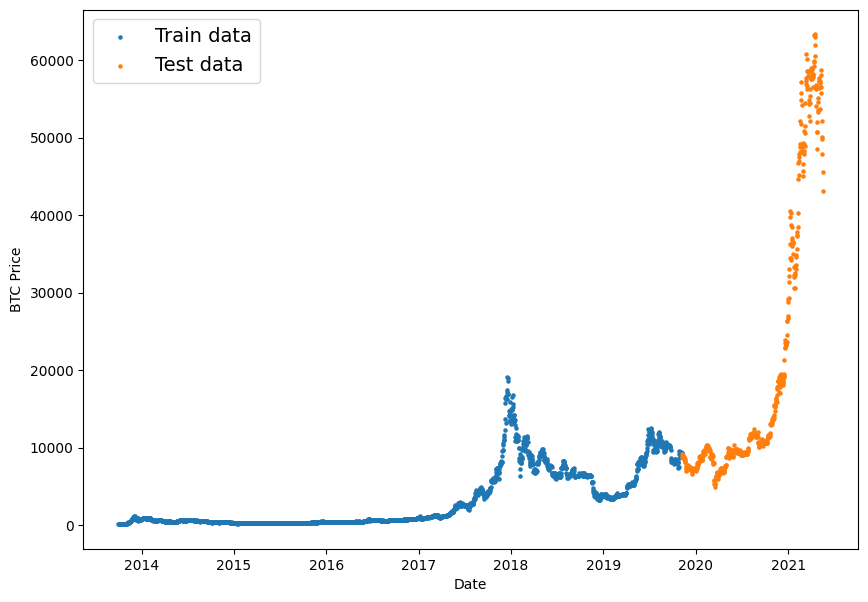

In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [15]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):

  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

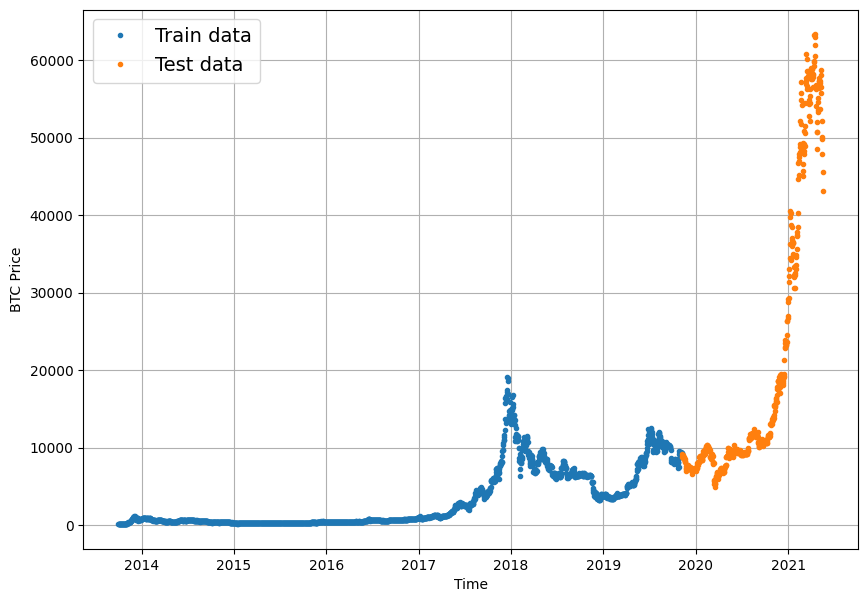

In [16]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# 2.Model 0: Naive forecast (baseline)

In [17]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

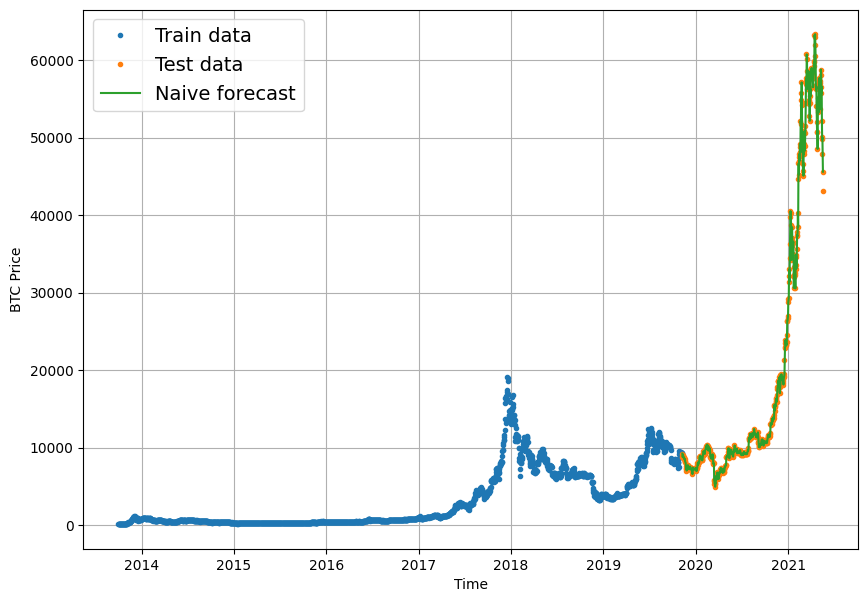

In [18]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

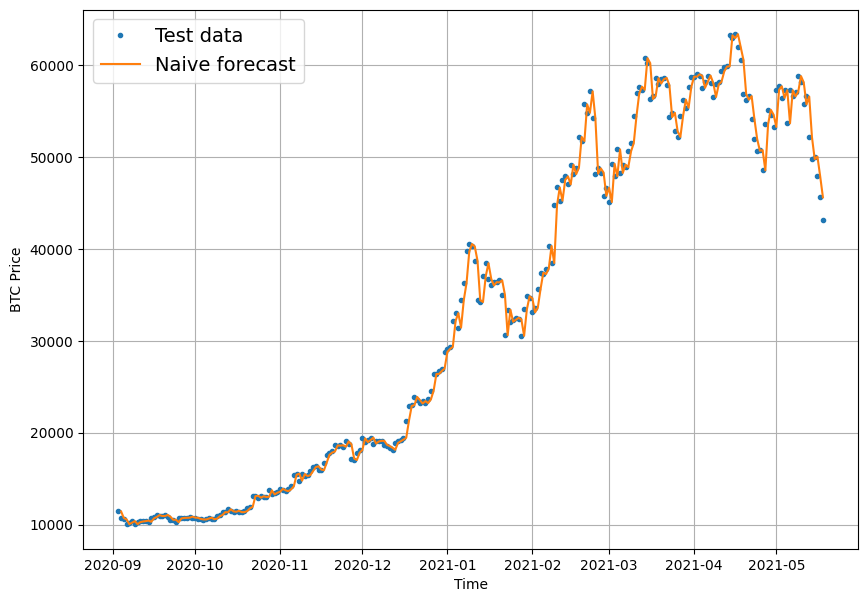

In [19]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [20]:
def mean_absolute_scaled_error(y_true, y_pred):

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

In [21]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.5165248),
 'mase': np.float32(0.99957)}

In [23]:
tf.reduce_mean(y_test).numpy()

np.float64(20056.632963737226)

# 3.Model 1: Dense model (window=7, horizon=1)

## Turn data into windowing dataset

In [24]:
HORIZON = 1
WINDOW_SIZE = 7

In [25]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [26]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [27]:
def make_windows(x, window_size=7, horizon=1):

  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [28]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [29]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [30]:
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turn window into training and test sets

In [31]:
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

In [34]:
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)

In [35]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Building a model

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense.keras")

model_1.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2549.5886 - mae: 2549.5886 - val_loss: 918.4757 - val_mae: 918.4757
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 340.1381 - mae: 340.1381 - val_loss: 1482.7538 - val_mae: 1482.7538
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 217.4005 - mae: 217.4005 - val_loss: 861.7708 - val_mae: 861.7708
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 155.5201 - mae: 155.5201 - val_loss: 885.6943 - val_mae: 885.6943
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 147.4016 - mae: 147.4016 - val_loss: 856.3976 - val_mae: 856.3976
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 141.4416 - mae: 141.4416 - val_loss: 814.8377 - val_mae: 814.8377
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 138.5680 - mae: 138.5680 - val_loss: 802.9041 - val_mae: 802.9041
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 136.9397 - mae: 136.9397 - val_loss: 787.6871 - val_mae: 787.

In [37]:
test_windows.shape, test_labels.shape

((556, 7), (556, 1))

## Model evaluation

In [38]:
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282.9333 - mae: 282.9333 


[565.4171142578125, 565.4171142578125]

In [39]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense.keras")
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 282.9333 - mae: 282.9333  


[565.4171142578125, 565.4171142578125]

## Prediction on test dataset

In [40]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [41]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.459, 8788.574, 9049.859, 8802.266, 8737.697, 8738.839,
        8722.182, 8511.186, 8478.188, 8541.939], dtype=float32)>)

In [42]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': np.float32(565.4171),
 'mse': np.float32(1162184.0),
 'rmse': np.float32(1078.0464),
 'mape': np.float32(2.5252087),
 'mase': np.float32(0.99328125)}

In [43]:
naive_results

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.5165248),
 'mase': np.float32(0.99957)}

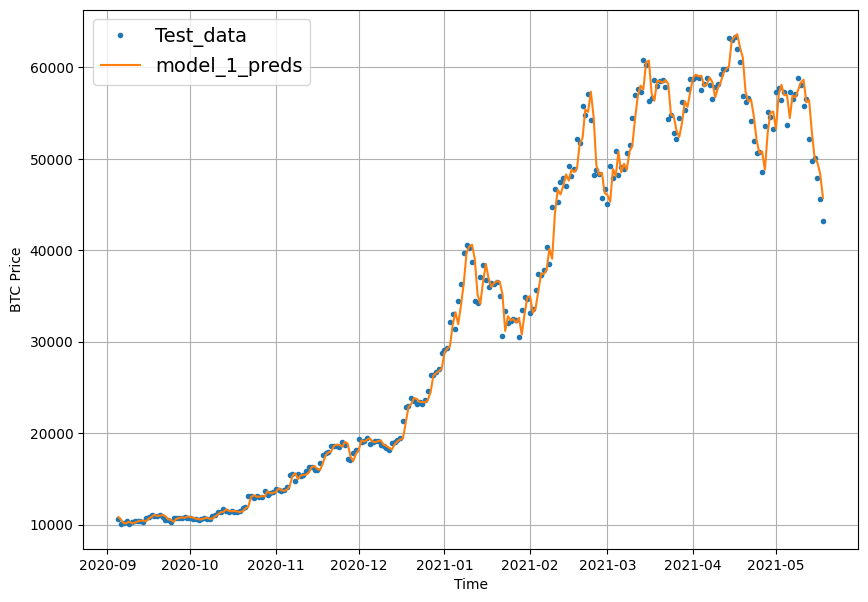

In [44]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

# 4.Model 2: Dense (window=30, horizon=1)

In [45]:
HORIZON = 1
WINDOW_SIZE = 30

In [46]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [47]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [48]:
train_windows

array([[ 123.65499   ,  125.455     ,  108.58483   , ...,  187.15983   ,
         192.75666   ,  197.4       ],
       [ 125.455     ,  108.58483   ,  118.67466   , ...,  192.75666   ,
         197.4       ,  196.02499   ],
       [ 108.58483   ,  118.67466   ,  121.33866   , ...,  197.4       ,
         196.02499   ,  198.04883   ],
       ...,
       [8320.1715814 , 8328.60426039, 8282.17732583, ..., 9226.48582088,
        8794.35864452, 8798.04205463],
       [8328.60426039, 8282.17732583, 8337.81899854, ..., 8794.35864452,
        8798.04205463, 9081.18687849],
       [8282.17732583, 8337.81899854, 8162.44      , ..., 8798.04205463,
        9081.18687849, 8711.53433917]])

In [49]:
train_labels

array([[ 196.02499   ],
       [ 198.04883   ],
       [ 198.93233   ],
       ...,
       [9081.18687849],
       [8711.53433917],
       [8760.89271814]])

## Building a model

In [50]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense.keras")

model_2.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

## Model evaluation

In [51]:
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 333.4059 


642.3187255859375

In [52]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense.keras")
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 320.9331 


630.4913330078125

## Prediction on test dataset

In [53]:
model_2_preds = make_preds(model_2, input_data=test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [54]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': np.float32(630.4913),
 'mse': np.float32(1347065.8),
 'rmse': np.float32(1160.6316),
 'mape': np.float32(2.8569703),
 'mase': np.float32(1.1021048)}

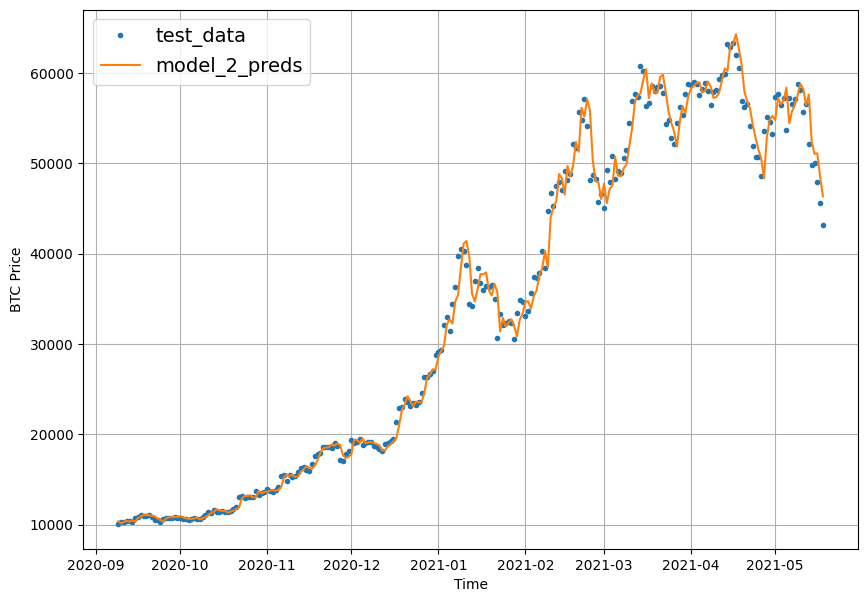

In [55]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

# 5.Model 3: Dense (window=30, horizon=7)

In [56]:
HORIZON = 7
WINDOW_SIZE = 30
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [57]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [58]:
train_windows

array([[ 123.65499   ,  125.455     ,  108.58483   , ...,  187.15983   ,
         192.75666   ,  197.4       ],
       [ 125.455     ,  108.58483   ,  118.67466   , ...,  192.75666   ,
         197.4       ,  196.02499   ],
       [ 108.58483   ,  118.67466   ,  121.33866   , ...,  197.4       ,
         196.02499   ,  198.04883   ],
       ...,
       [7853.69330483, 8236.2083793 , 8201.63781819, ..., 9290.89660239,
        9202.41545055, 9369.62808116],
       [8236.2083793 , 8201.63781819, 8572.38081243, ..., 9202.41545055,
        9369.62808116, 9326.59962378],
       [8201.63781819, 8572.38081243, 8582.1445177 , ..., 9369.62808116,
        9326.59962378, 9335.75240233]])

In [59]:
train_labels

array([[ 196.02499   ,  198.04883   ,  198.93233   , ...,  210.3075    ,
         225.02      ,  248.25333   ],
       [ 198.04883   ,  198.93233   ,  200.543     , ...,  225.02      ,
         248.25333   ,  262.32666   ],
       [ 198.93233   ,  200.543     ,  210.3075    , ...,  248.25333   ,
         262.32666   ,  294.48699   ],
       ...,
       [9326.59962378, 9335.75240233, 9226.48582088, ..., 8798.04205463,
        9081.18687849, 8711.53433917],
       [9335.75240233, 9226.48582088, 8794.35864452, ..., 9081.18687849,
        8711.53433917, 8760.89271814],
       [9226.48582088, 8794.35864452, 8798.04205463, ..., 8711.53433917,
        8760.89271814, 8749.52059102]])

## Building a model

In [60]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense.keras")

model_3.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

## Model evaluation

In [61]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 637.0995 


1295.1805419921875

In [62]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense.keras")
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 627.1917 


1273.718017578125

## Prediction on test dataset

In [63]:
model_3_preds = make_preds(model_3, input_data=test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9382.701 , 9447.914 , 9064.566 , 9161.733 , 9162.271 , 9408.626 ,
        9127.459 ],
       [9034.498 , 9092.06  , 8713.529 , 8836.144 , 8856.225 , 9040.1045,
        8855.857 ],
       [8797.915 , 8818.3955, 8460.6   , 8816.788 , 8869.424 , 8757.378 ,
        8819.866 ],
       [9058.987 , 9081.957 , 8826.813 , 8970.102 , 9064.578 , 8907.401 ,
        9009.114 ],
       [8965.327 , 9003.02  , 8892.331 , 8820.688 , 8824.987 , 8777.143 ,
        8813.076 ]], dtype=float32)>

In [64]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': array([ 462.28668 ,  167.08957 ,  225.3552  ,  361.8273  ,  316.5911  ,
         448.88345 ,  318.75223 ,  299.02826 ,  353.2336  ,  473.41275 ,
         660.24805 ,  682.7377  ,  725.19965 ,  657.33044 ,  506.94098 ,
         251.82498 ,  274.43158 ,  351.23492 ,  392.62234 ,  373.82693 ,
         210.74463 ,  136.9368  ,  168.00293 ,  129.24232 ,  153.30873 ,
         190.95738 ,  191.87416 ,  212.64355 ,  149.27693 ,  115.519394,
         199.05685 ,  280.20285 ,  183.68422 ,  251.32896 ,  252.91232 ,
         207.426   ,  237.4331  ,  245.56584 ,  260.17368 ,  362.33627 ,
         616.74713 ,  194.99463 ,  240.00803 ,  103.260254,   73.31466 ,
          85.5662  ,  138.6176  ,   99.65883 ,  115.22991 ,   93.50893 ,
         150.66545 ,  105.73591 ,  178.3547  ,  192.74281 ,  392.75342 ,
         429.55826 ,  686.7892  ,  608.45526 ,  580.16736 ,  595.34015 ,
         475.40793 ,  331.2449  ,  293.3533  ,  438.22342 ,  453.28516 ,
         606.13776 ,  547.2054  ,  662.17126

In [65]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  mae = tf.keras.metrics.mae(y_true, y_pred)
  mse = tf.keras.metrics.mse(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mape(y_true, y_pred)
  mase = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [66]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': np.float32(1273.718),
 'mse': np.float32(5525140.5),
 'rmse': np.float32(1458.0657),
 'mape': np.float32(5.6242657),
 'mase': np.float32(561.9733)}

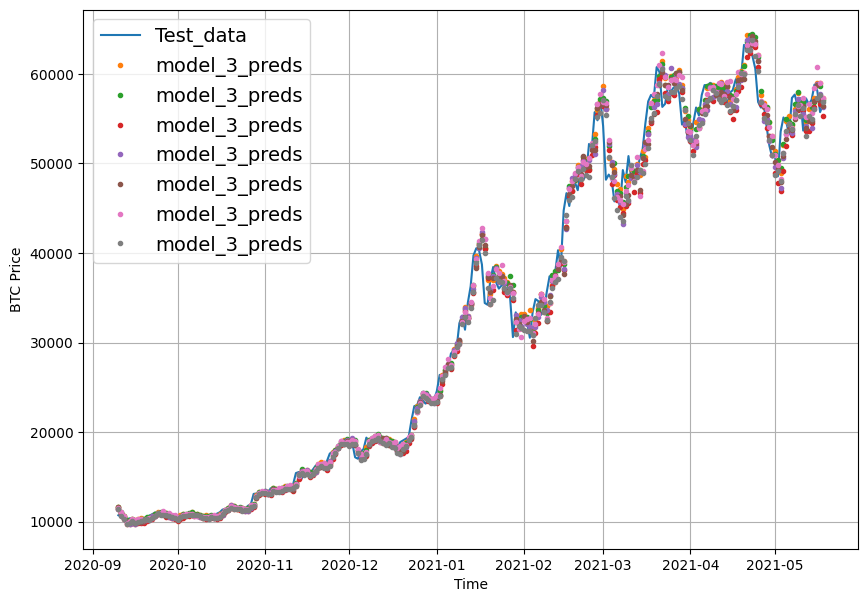

In [67]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, format="-", label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

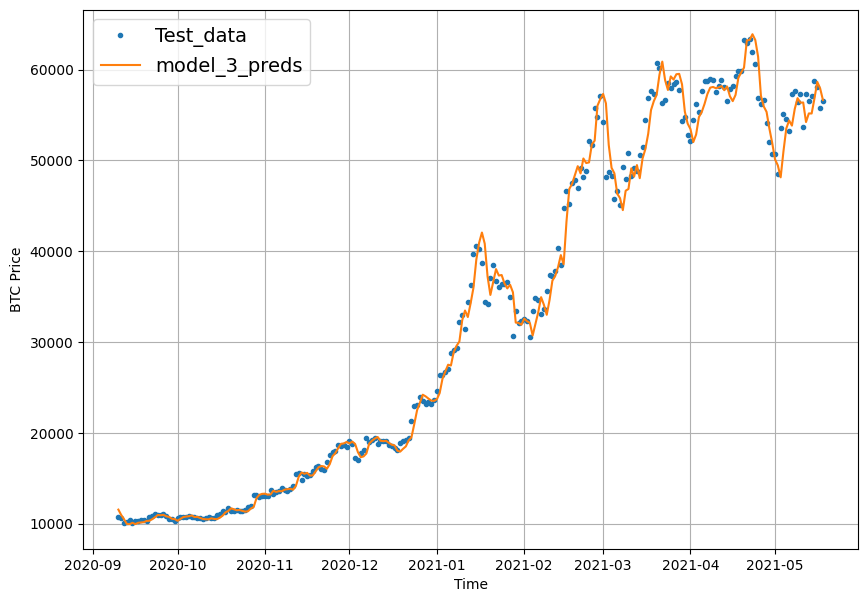

In [68]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Comparison on performance

<Axes: >

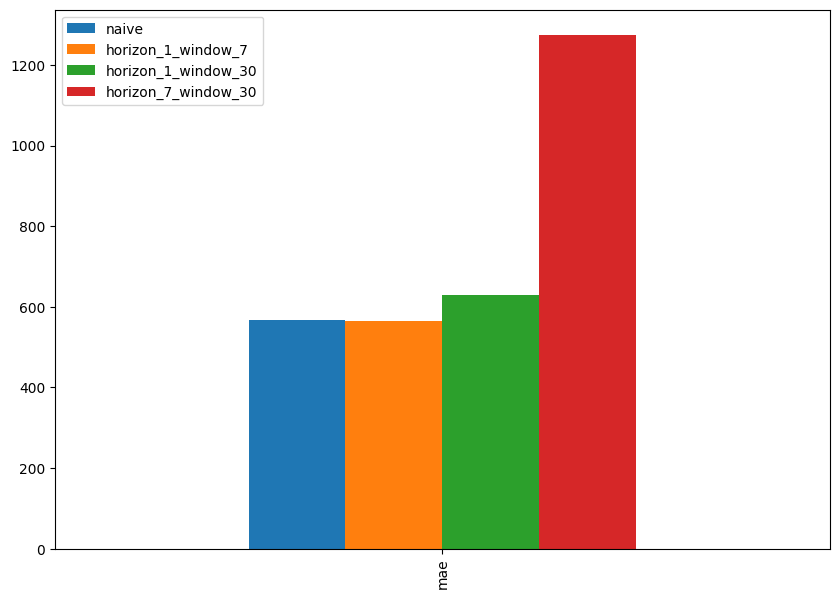

In [69]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

# 6.Model 4: Conv1D

In [70]:
HORIZON = 1
WINDOW_SIZE = 7

In [71]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [72]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [73]:
train_windows[0].shape # returns (WINDOW_SIZE, )      # (batch_size, timesteps, input_dim)

(7,)

In [74]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [75]:
train_windows

array([[ 123.65499   ,  125.455     ,  108.58483   , ...,  121.33866   ,
         120.65533   ,  121.795     ],
       [ 125.455     ,  108.58483   ,  118.67466   , ...,  120.65533   ,
         121.795     ,  123.033     ],
       [ 108.58483   ,  118.67466   ,  121.33866   , ...,  121.795     ,
         123.033     ,  124.049     ],
       ...,
       [9225.99547934, 9131.41063031, 9197.63234462, ..., 9202.41545055,
        9369.62808116, 9326.59962378],
       [9131.41063031, 9197.63234462, 9290.89660239, ..., 9369.62808116,
        9326.59962378, 9335.75240233],
       [9197.63234462, 9290.89660239, 9202.41545055, ..., 9326.59962378,
        9335.75240233, 9226.48582088]])

In [76]:
train_labels

array([[ 123.033     ],
       [ 124.049     ],
       [ 125.96116   ],
       ...,
       [9335.75240233],
       [9226.48582088],
       [8794.35864452]])

In [77]:
def create_model_checkpoint1(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)

## Build a model

In [78]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D.keras")

model_4.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint1(model_name=model_4.name)])

In [79]:
model_4.summary()

Model: "model_4_conv1D.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

## Model evaluation

In [80]:
model_4.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 284.4273 


569.9483032226562

## Prediction on test dataset

In [81]:
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8884.695, 8784.047, 9011.615, 8789.192, 8740.894, 8748.316,
       8680.078, 8526.604, 8470.047, 8518.708], dtype=float32)>

In [82]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': np.float32(569.9483),
 'mse': np.float32(1179427.0),
 'rmse': np.float32(1086.0143),
 'mape': np.float32(2.5442224),
 'mase': np.float32(569.2417)}

# 7.Model 5: RNN (LSTM)

## Building a model

In [83]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))

x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm.keras")

model_5.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2428.8203 - val_loss: 6919.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 631.9178 - val_loss: 1026.1316
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 185.7856 - val_loss: 978.6640
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 173.3987 - val_loss: 956.9142
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 160.2416 - val_loss: 902.7962
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 154.1064 - val_loss: 826.8636
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 145.7329 - val_loss: 803.4119
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 142.0816 - val_loss: 871.3990
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 150.9927 - val_loss: 932.2802
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 165.1543 - val_loss: 946.4252
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 160.7597 - val_loss: 951.6599
Epoch 12/100


## Model evaluation

In [84]:
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 287.1111 


572.8721923828125

## Prediciton on test dataset

In [85]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8894.384, 8782.471, 9003.696, 8804.778, 8724.728, 8727.804,
       8694.833, 8528.773, 8457.663, 8519.395], dtype=float32)>

In [86]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': np.float32(572.8722),
 'mse': np.float32(1190198.5),
 'rmse': np.float32(1090.9622),
 'mape': np.float32(2.5714197),
 'mase': np.float32(569.2417)}

# 8.Model 6: Dense (multivariate time series)

## Making a multivariate time series

In [87]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [88]:
block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [89]:
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [90]:
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [91]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


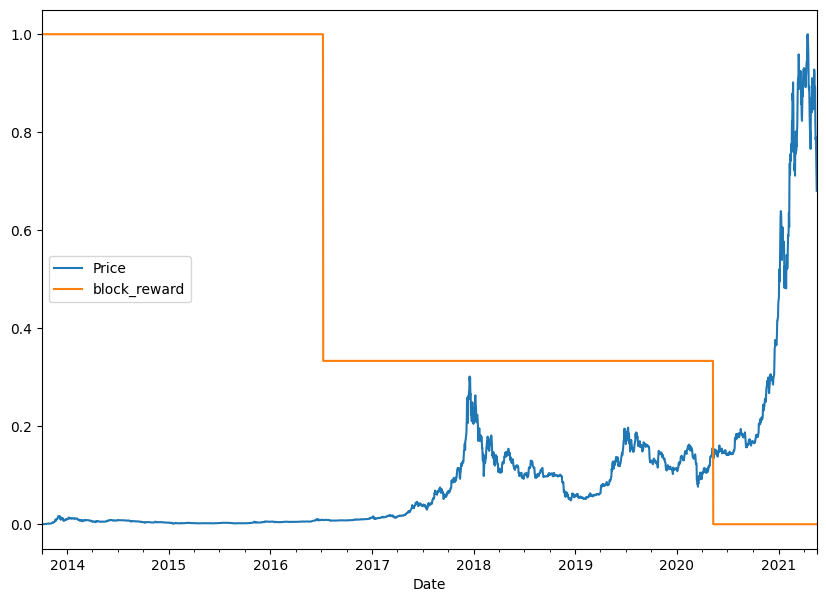

In [92]:
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), columns=bitcoin_prices_block.columns, index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset

In [93]:
HORIZON = 1
WINDOW_SIZE = 7

In [94]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [95]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [96]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Building a model

In [97]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate.keras")

model_6.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

## Model evaluation

In [98]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate.keras")
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 283.9292 


571.2173461914062

## Prediction on test dataset

In [99]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8787.358, 8759.486, 9026.703, 8757.25 , 8706.791, 8700.496,
       8639.474, 8486.906, 8419.689, 8504.801], dtype=float32)>

In [100]:
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': np.float32(571.2173),
 'mse': np.float32(1159644.4),
 'rmse': np.float32(1076.8678),
 'mape': np.float32(2.5628753),
 'mase': np.float32(569.2417)}

In [101]:
model_1_results

{'mae': np.float32(565.4171),
 'mse': np.float32(1162184.0),
 'rmse': np.float32(1078.0464),
 'mape': np.float32(2.5252087),
 'mase': np.float32(0.99328125)}

# 9.Model 7: N-BEATS algorithm

In [102]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [103]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, theta_size=WINDOW_SIZE+HORIZON,horizon=HORIZON, n_neurons=128, n_layers=4)

In [104]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [105]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.09317178 -0.22344083  0.1468943   0.04514994 -0.6732521   0.34639955
  0.08141876]
Forecast: 0.49269556999206543


## Preparing data

In [106]:
HORIZON = 1
WINDOW_SIZE = 7

In [107]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [108]:
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [109]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## Setup hyperparameters

In [110]:
N_EPOCHS = 10       # 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON
INPUT_SIZE, THETA_SIZE

(7, 8)

## Building a model

In [111]:
tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

for i, _ in enumerate(range(N_STACKS-1)):
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_N-BEATS")


model_7.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["mae", "mse"])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[create_model_checkpoint(model_name=model_7.name+'.keras'),
                      tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - loss: 32327.5098 - mae: 32327.5098 - mse: 4350817792.0000 - val_loss: 5101.3096 - val_mae: 5101.3096 - val_mse: 50527420.0000 - learning_rate: 0.0010
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 3903.0967 - mae: 3903.0967 - mse: 60334096.0000 - val_loss: 8254.7842 - val_mae: 8254.7842 - val_mse: 122108792.0000 - learning_rate: 0.0010
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 431.8578 - mae: 431.8578 - mse: 852047.5000 - val_loss: 7820.1968 - val_mae: 7820.1968 - val_mse: 108534792.0000 - learning_rate: 0.0010
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 1048.5330 - mae: 1048.5330 - mse: 3634014.7500 - val_loss: 10630.9375 - val_mae: 10630.9375 - val_mse: 228183008.0000 - learning_rate: 0.0010
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 2422.4304 - mae: 2422.4304 - mse: 21647060.0000 - val_loss: 1705.2347 - val_mae: 1705.2347 - val_mse: 9539625.0000 - learning_rate: 0.0010
Epoch 6/10
3/3 ━━━━━

In [112]:
model_7.summary()

Model: "model_7_N-BEATS"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ stack_input         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ InitialBlock        │ [(None, 7),       │    796,168 │ stack_input[0][0] │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_00         │ (None, 7)         │          0 │ stack_input[0][0… │
│ (Subtract)          │                   │            │ InitialBlock[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_0       │ [(None, 7),       │    796,168 │ subtract_00[0][0] │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_0          │ (None, 7)         │          0 │ subtract_00[0][0… │
│ (Subtract)          │                   │            │ NBeatsBlock_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_1       │ [(None, 7),       │    796,168 │ subtract_0[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 7)         │          0 │ subtract_0[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_2       │ [(None, 7),       │    796,168 │ subtract_1[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 7)         │          0 │ subtract_1[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_3       │ [(None, 7),       │    796,168 │ subtract_2[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 7)         │          0 │ subtract_2[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_4       │ [(None, 7),       │    796,168 │ subtract_3[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_4          │ (None, 7)         │          0 │ subtract_3[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_5       │ [(None, 7),       │    796,168 │ subtract_4[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 7)         │          0 │ subtract_4[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_6       │ [(None, 7),       │    796,168 │ subtract_5[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_6          │ (None, 7)         │          0 │ subtract_5[0][0]

 Total params: 71,655,122 (273.34 MB)

 Trainable params: 23,885,040 (91.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,770,082 (182.23 MB)

## Model evaluation

In [113]:
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - loss: 1047.6025 - mae: 1047.6025 - mse: 3232024.5000


[1047.6025390625, 1047.6025390625, 3232024.5]

## Prediction on test dataset

In [114]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([9030.388, 9014.819, 8987.774, 8866.574, 8826.363, 8679.428,
       8664.717, 8585.824, 8533.1  , 8481.484], dtype=float32)>

In [115]:
model_7_results = evaluate_preds(y_true=y_test, y_pred=model_7_preds)
model_7_results

{'mae': np.float32(1047.6027),
 'mse': np.float32(3232024.2),
 'rmse': np.float32(1797.7832),
 'mape': np.float32(4.6879478),
 'mase': np.float32(569.2417)}

# 10.Model 8: Ensemble model

## Building a model

In [116]:
def get_ensemble_models(horizon=HORIZON, train_data=train_dataset, test_data=test_dataset, num_iter=10, num_epochs=100, loss_fns=["mae", "mse", "mape"]):

  ensemble_models = []
  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=["mae", "mse"])

      model.fit(train_data,
                epochs=num_epochs,
                verbose=1,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
      ensemble_models.append(model)
  return ensemble_models

In [117]:
ensemble_models = get_ensemble_models(num_iter=1, num_epochs=5)
ensemble_models

Optimizing model by reducing: mae for 5 epochs, model number: 0
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 404.1113 - mae: 404.1113 - mse: 627967.3750 - val_loss: 1288.2719 - val_mae: 1288.2719 - val_mse: 4724793.0000 - learning_rate: 0.0010
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 428.6013 - mae: 428.6013 - mse: 726670.3750 - val_loss: 1278.6256 - val_mae: 1278.6256 - val_mse: 3998620.0000 - learning_rate: 0.0010
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 285.6798 - mae: 285.6798 - mse: 392585.1875 - val_loss: 1111.9158 - val_mae: 1111.9158 - val_mse: 3789292.0000 - learning_rate: 0.0010
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 192.0796 - mae: 192.0796 - mse: 179884.4375 - val_loss: 865.2770 - val_mae: 865.2770 - val_mse: 2312639.0000 - learning_rate: 0.0010
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 194.2813 - mae: 194.2813 - mse: 213175.9375 - val_loss: 808.7125 - val_mae: 808.7125 - val_mse: 2164471.0000 - learning_r

[<Sequential name=sequential, built=True>,
 <Sequential name=sequential_1, built=True>,
 <Sequential name=sequential_2, built=True>]

## Prediction on test dataset

In [118]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [119]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models, data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<tf.Tensor: shape=(3, 556), dtype=float32, numpy=
array([[ 9028.911,  8705.527,  8900.984, ..., 50035.484, 48118.203,
        43571.977],
       [10436.874, 10464.377, 10279.908, ..., 59081.562, 54716.234,
        54088.04 ],
       [11568.781, 11478.201, 11581.959, ..., 72325.25 , 72316.93 ,
        66140.42 ]], dtype=float32)>

In [120]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': np.float32(2548.4705),
 'mse': np.float32(14515312.0),
 'rmse': np.float32(3809.8965),
 'mape': np.float32(13.194613),
 'mase': np.float32(569.2417)}

In [121]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([10344.855 , 10216.035 , 10254.284 , 10000.321 ,  9745.819 ,
        9991.614 ,  9854.245 ,  9699.903 ,  9681.927 ,  9659.233 ,
        9508.565 ,  9326.047 ,  9376.067 ,  9134.005 ,  8797.992 ,
        8730.937 ,  8472.347 ,  8085.0757,  8103.1445,  8030.924 ,
        8146.525 ,  8163.9907,  8434.63  ,  8341.36  ,  8445.488 ,
        8434.102 ,  8248.546 ,  8181.315 ,  8254.344 ,  8214.962 ,
        8291.686 ,  8389.722 ,  8336.327 ,  8334.187 ,  8207.5205,
        8096.0015,  8045.0566,  7997.4595,  8017.3804,  7821.287 ,
        7885.3413,  7987.639 ,  7591.2954,  8054.3335,  8195.599 ,
        8002.5703,  8082.602 ,  8136.1875,  8050.0156,  8065.5093,
        8110.5913,  8114.4116,  8119.056 ,  8129.344 ,  8192.431 ,
        8092.9146,  7998.0444,  8107.7085,  7973.1245,  8179.013 ,
        8472.859 ,  8539.917 ,  8660.677 ,  8942.9795,  9118.973 ,
        8911.638 ,  9000.27  ,  9202.086 ,  9425.63  ,  9348.152 ,
        9693.4

In [122]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median

array([10436.874 , 10464.377 , 10279.908 ,  9986.365 ,  9978.58  ,
        9927.569 ,  9958.863 , 10045.76  ,  9635.123 ,  9822.805 ,
        9572.823 ,  9454.739 ,  9358.9375,  9019.049 ,  8805.066 ,
        8447.997 ,  8166.603 ,  8056.5605,  7851.4395,  8056.954 ,
        8396.326 ,  8444.108 ,  8613.59  ,  8594.394 ,  8904.873 ,
        8421.167 ,  8509.362 ,  8247.328 ,  8343.938 ,  8456.102 ,
        8626.25  ,  8577.881 ,  8633.906 ,  8490.842 ,  8275.267 ,
        8228.353 ,  8052.5303,  8152.1323,  8092.0815,  7851.9365,
        8129.3975,  7864.3623,  7999.8325,  8347.523 ,  8175.8345,
        8233.414 ,  8170.343 ,  8302.2   ,  8333.339 ,  8262.19  ,
        8284.247 ,  8401.386 ,  8351.835 ,  8370.611 ,  8394.849 ,
        8199.028 ,  8246.066 ,  8154.881 ,  8202.961 ,  8435.881 ,
        8674.028 ,  8398.594 ,  8807.967 ,  9252.764 ,  9486.217 ,
        9376.037 ,  9337.395 ,  9464.385 ,  9438.979 ,  9602.273 ,
        9774.574 , 10324.564 , 10310.147 , 10193.215 , 10008.1

In [123]:
def get_upper_lower(preds):

  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

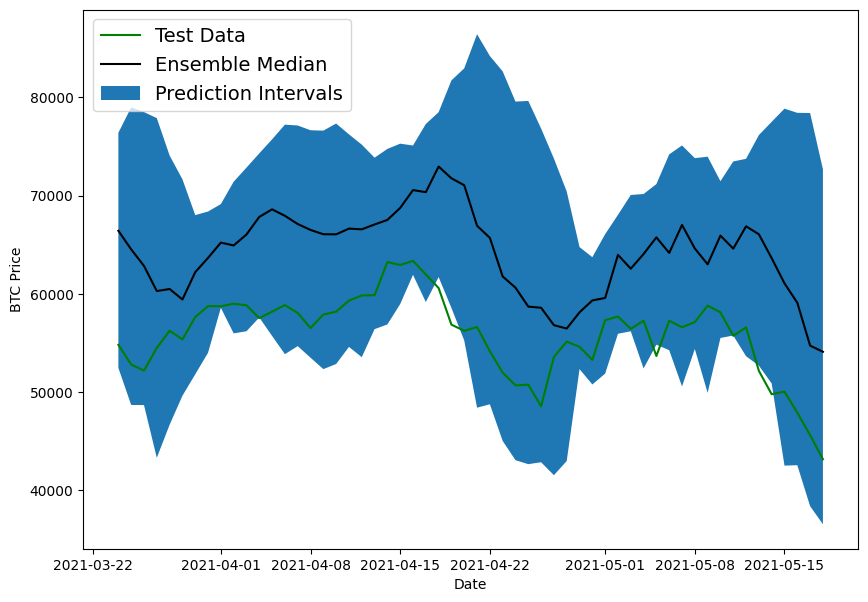

In [124]:
ensemble_median = np.median(ensemble_preds, axis=0)
offset=500

plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], (lower)[offset:], (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

# 11.Model 9: Dense on full data

In [125]:
HORIZON, WINDOW_SIZE

(1, 7)

In [126]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [127]:
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [128]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

## Building a model

In [129]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

model_9.compile(loss=tf.keras.losses.mae, optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all, epochs=100, verbose=0)

In [130]:
model_9.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,997 (207.02 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,332 (138.02 KB)

## Prediction on test dataset

In [131]:
INTO_FUTURE = 14

In [132]:
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:

  future_forecast = []
  last_window = values[-WINDOW_SIZE:]
  for _ in range(into_future):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    future_forecast.append(tf.squeeze(future_pred).numpy())
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  return future_forecast

In [133]:
future_forecast = make_future_forecast(values=y_all, model=model_9, into_future=INTO_FUTURE, window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55656.23046875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55656.23046875] -> Prediction: 50773.50390625

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55656.23046875 50773.50390625] -> Prediction: 49378.44921875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55656.23046875 50773.50390625 49378.44921875] -> Prediction: 47710.9609375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55656.23046875
 50773.50390625 49378.44921875 47710.9609375 ] -> Prediction: 47932.4609375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms

In [134]:
bitcoin_prices_windowed.tail(1)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [135]:
def get_future_dates(start_date, into_future, offset=1):

  start_date = start_date + np.timedelta64(offset, "D")
  end_date = start_date + np.timedelta64(into_future, "D")
  return np.arange(start_date, end_date, dtype="datetime64[D]")

In [136]:
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [137]:
next_time_steps = get_future_dates(start_date=last_timestep, into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [138]:
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55656.23 , 50773.504, 49378.45 , 47710.96 , 47932.46 ,
        45924.17 , 48243.06 , 53774.242, 49652.945, 48177.254, 47191.98 ,
        47990.527, 47520.137, 50306.258], dtype=float32))

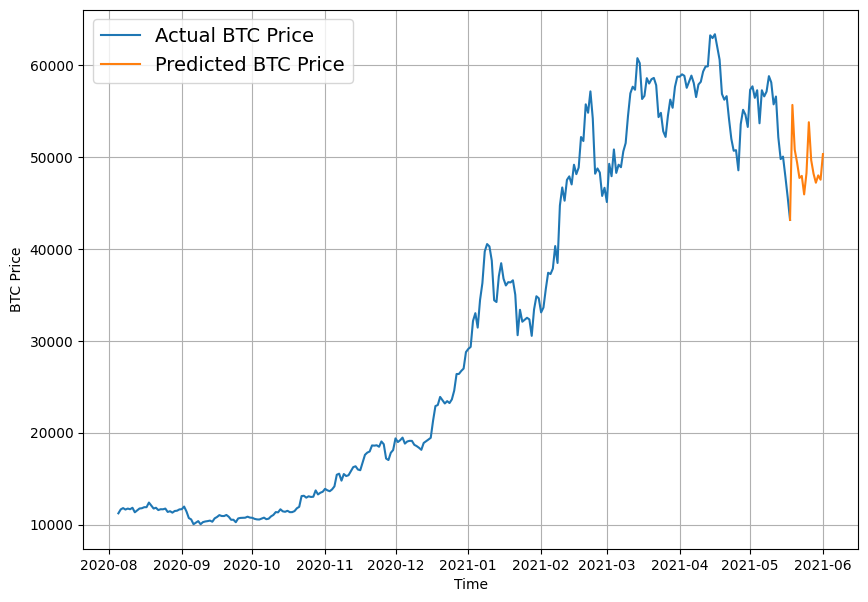

In [139]:
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

# 12.Compare Models

In [143]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,565.417114,1.162184e+06,1078.046387,2.525209,0.993281
model_2_dense_w30_h1,630.491272,1.347066e+06,1160.631592,2.856970,1.102105
model_3_dense_w30_h7,1273.718018,5.525140e+06,1458.065674,5.624266,561.973328
model_4_CONV1D,569.948303,1.179427e+06,1086.014282,2.544222,569.241699
model_5_LSTM,572.872192,1.190198e+06,1090.962158,2.571420,569.241699
model_6_multivariate,571.217285,1.159644e+06,1076.867798,2.562875,569.241699
model_8_NBEATs,1047.602661,3.232024e+06,1797.783203,4.687948,569.241699
model_9_ensemble,2548.470459,1.451531e+07,3809.896484,13.194613,569.241699


from matplotlib import pyplot as plt
_df_12['mae'].plot(kind='hist', bins=20, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['mse'].plot(kind='hist', bins=20, title='mse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['rmse'].plot(kind='hist', bins=20, title='rmse')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['mape'].plot(kind='hist', bins=20, title='mape')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='mae', y='mse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='mse', y='rmse', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18.plot(kind='scatter', x='rmse', y='mape', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='mape', y='mase', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_21['mse'].plot(kind='line', figsize=(8, 4), title='mse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_22['rmse'].plot(kind='line', figsize=(8, 4), title='rmse')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['mape'].plot(kind='line', figsize=(8, 4), title='mape')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

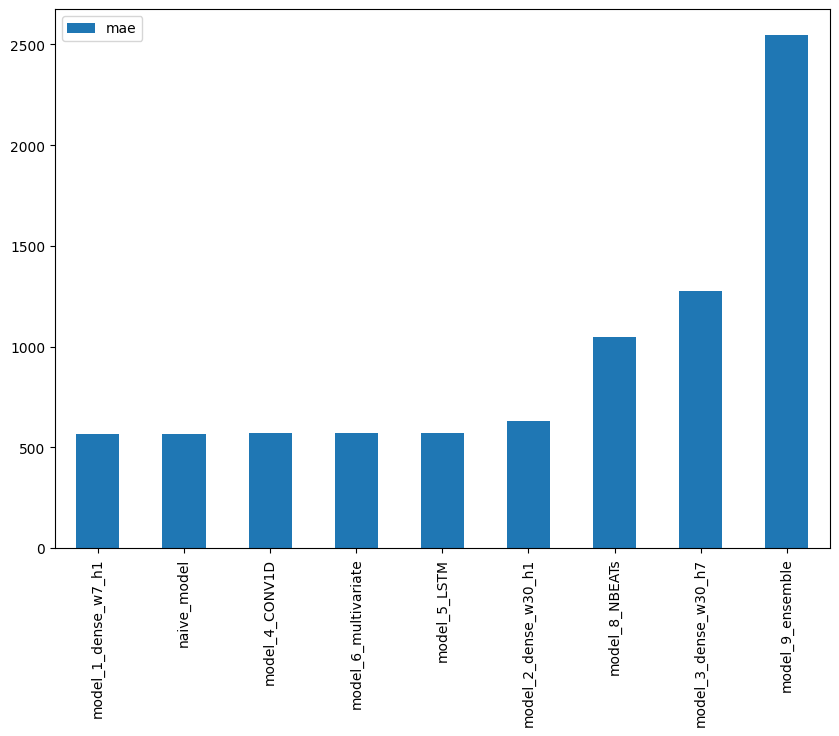

In [141]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")